<h1 style="text-align: center;font-family: Babas;" markdown="1">Decoder Layer</h1>

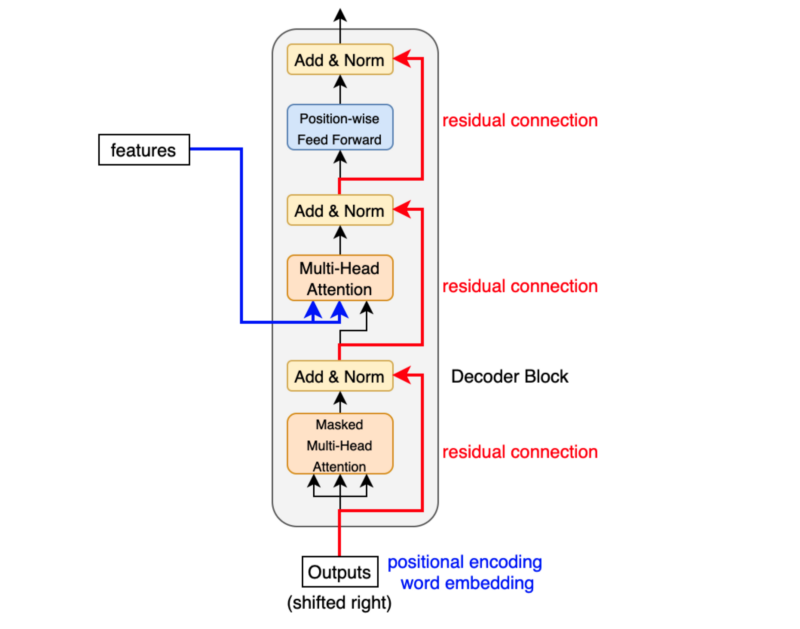

In [17]:
import torch
import math
from torch import nn
import torch.nn.functional as F

## Scaled-dot Product
(*To calculate self-attention*)

In [18]:
def scaled_dot_product(q, k, v, mask = None):
    # q,k,v = 30 X 8 X 200 X 64
    d_k =q.size()[-1] # 64
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 X 8 X 200 X 200
    print(f"scaled.size(): {scaled.size()}")
    if mask is not None:
        print(f" -- Adding Mask of shape {mask.size()} --")
        scaled += mask # 30 X 8 X 200 X 200
    attention = F.softmax(scaled, dim= -1) # 30 X 8 X 200 X 200
    values = torch.matmul(attention, v) # 30 X 8 X 200 X 64 // 64 is here the embedding of the value tensor
    return values, attention

## Masked Multi-head Attention

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model # 512
        self.num_heads =num_heads # 8
        self.head_dim = d_model//num_heads # 64
        self.qkv_layer = nn.Linear(d_model, 3*d_model) # 512 X 1536
        self.linear_layer = nn.Linear(d_model, d_model) # 512 X 512
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 X 200 X 512
        print(f"x.size(): {x.size()}")

        qkv = self.qkv_layer(x) # 30 X 200 X 1536
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.reshape( batch_size, sequence_length, self.num_heads, 3*self.head_dim) # 30 X 200 X 8 X 192 // to have multi-headed self attn.
        print(f"qkv.size() after reshape: {qkv.size()}")

        qkv = qkv.permute( 0, 2, 1, 3) # 30 X 8 X 200 X 192
        print(f"qkv.size() after permute: {qkv.size()}")

        q, k, v = qkv.chunk(3, dim=-1) # each are 30 X 8 X 200 X 64
        print(f" -> q size: {q.size()}\n -> k size: {k.size()}\n -> v size: {v.size()} ")

        values, attention = scaled_dot_product(q, k, v, mask) # Values = 30 X 8 X 200 X 64 || attention = 30 X 8 X 200 X 200  
        print(f" => values.size(): {values.size()}\n => attention.size() : {attention.size()}")

        values = values.reshape( batch_size, sequence_length, self.num_heads*self.head_dim) # 30 X 200 X 512(8*64)
        print(f"values.size() after merging all heads: {values.size()}")

        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")

        return out

## Layer Normalization
( *ADD & NORM* )

In [20]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps = 1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape # [512]
        self.eps=eps
        self.gamma=nn.Parameter(torch.ones(parameters_shape)) # [512]
        self.beta =nn.Parameter(torch.ones(parameters_shape)) # [512]
    
    def forward(self,inputs): # 30 X 200 X 512
        dims = [-(i+1) for i in range(len(self.parameters_shape))] #[-1] // along  which layer we want to perform layer norm.

        mean = inputs.mean(dim=dims, keepdim=True) # 30 X 200 X 1 # mean of all 512 is single value
        print(f" Mean size: {mean.size()}")

        var = ((inputs-mean)**2).mean(dim=dims, keepdim=True) # 30 X 200 X 1
        std=(var+self.eps).sqrt() # 30 X 200 X 1
        print(f"S.D size: {std.size()}")

        y=(inputs-mean)/std # 30 X 200 X 512
        print(f"y size: {y.size()}")

        out=self.gamma*y + self.beta
        print(f" -> self.gamma: {self.gamma.size()}\n -> self.beta: {self.beta.size()}")
        print(f"out size: {out.size()}")
        
        return out

## Multi-head Attention
( *Cross attention* )

In [21]:
class MultiHeadCrossAttention(nn.Module): # The only difference is in q + kv

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        # the only difference is we have kv and q as separate instead of qkv
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 1024 , we receive from the English side that is from the encoder
        self.q_layer = nn.Linear(d_model , d_model) # 512, we receive from the Hindi side that is from the decoder
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")

        kv = self.kv_layer(x) # 30 x 200 x 1024 // it comes from english side
        print(f"kv.size(): {kv.size()}")

        q = self.q_layer(y) # 30 x 200 x 512 // it comes from the Hindi side
        print(f"q.size(): {q.size()}")

        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)  # 30 x 200 x 8 x 128
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)  # 30 x 200 x 8 x 64
        
        kv = kv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 128
        q = q.permute(0, 2, 1, 3) # 30 x 8 x 200 x 64
       
        k, v = kv.chunk(2, dim=-1) # K: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64

        values, attention = scaled_dot_product(q, k, v, mask) #  30 x 8 x 200 x 64 // There is no mask this time.
        print(f" -> values: {values.size()}\n -> attention:{attention.size()}")

        values = values.reshape(batch_size, sequence_length, d_model) #  30 x 200 x 512
        out = self.linear_layer(values)  #  30 x 200 x 512
        print(f"out after passing through linear layer: {out.size()}")

        return out  #  30 x 200 x 512

## Position-wise Feed Forward

In [22]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionWiseFeedForward,self).__init__()
        self.linear1 = nn.Linear(d_model, hidden) # 512 X 2048
        self.linear2 = nn.Linear(hidden, d_model) # 2048 x 512
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = drop_prob)
    
    def forward(self, x): # 30 X 200 X 512

        x = self.linear1(x) # 30 X 200 X 2048
        print(f"x after first linear layer: {x.size()}")
        
        x = self.relu(x) # 30 X 200 X 2048
        print(f"x after relu activation: {x.size()}")
        
        x = self.dropout(x) # 30 X 200 X 2048
        print(f"x after dropout: {x.size()}")
        
        x = self.linear2(x) # 30 X 200 X 512
        print(f"x after second linear layer: {x.size()}")
        
        return x

## Decoder Layer
( *Single PASS* )

In [28]:
class DecoderLayer(nn.Module):
    num_instances=0
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()

        DecoderLayer.num_instances += 1
        self.layer_num = DecoderLayer.num_instances

        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape = [d_model])
        self.dropout1=nn.Dropout(p = drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape = [d_model])
        self.dropout2 = nn.Dropout( p =drop_prob)
        
        self.ffn = PositionWiseFeedForward(d_model = d_model, hidden = ffn_hidden, drop_prob = drop_prob)
        self.norm3 = LayerNormalization(parameters_shape = [d_model])
        self.dropout3 = nn.Dropout( p =drop_prob)
        

    def forward(self, x, y, decoder_mask):
        _y=y  # Residual Connection
        print(f"\n\n-----------------------------Decoder Layer {self.layer_num}----------------------------------------\n\n ----- Masked Multi-head ATTENTION ----- ")
        y = self.self_attention(y, mask = decoder_mask) # 30 X 200 X 512
        print("\n ----- DROPOUT 1 ----- ")
        y = self.dropout1(y) # 30 X 200 X 512
        print("\n ----- ADD & LAYER NORMALIZATION 1 ----- ")
        y = self.norm1(y + _y) # 30 X 200 X 512

        _y=y # 30 X 200 X 512
        print("\n ----- Multi-head attention (Cross attention) ----- ")
        y = self.encoder_decoder_attention(x, y, mask=None)
        print("\n----- DROPOUT 2 ----- ")
        y = self.dropout2(x) # 30 X 200 X 512
        print("\n ----- ADD AND LAYER NORM 2 ----- ")
        y = self.norm2(y + _y) # 30 X 200 X 512

        _y = y # 30 X 200 X 512
        print("\n ----- Position-wise FEED FORWARD 1 -----")
        y = self.ffn(y) # 30 X 200 X 512
        print("\n ----- DROP OUT 3 -----")
        y = self.dropout3(y) # 30 X 200 X 512
        print("\n ----- ADD & LAYER NORMALIZATION 3 ----- ")
        y = self.norm3(y + _y) # 30 X 200 X 512

        return y # 30 X 200 X 512
    

Sequential (custom)

In [29]:
class SequentialDecoder(nn.Sequential): # we have to implement our own sequential class because we have more than one input (x, y, mask)
    def forward(self, *inputs):
        x, y, mask = inputs
        for module in self._modules.values():
            y=module(x, y, mask) # 30 X 200 X 512
        return y

## Complete Decoder call

In [30]:
class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers=1):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])
        # Here instead of nn.Sequential we are creating our own SequentialDecoder class because nn.Seq doesn't take more than one input
        # And we have to pass 3 i.e, x, y, mask

    def forward(self, x, y, mask): # x (English) :30 X 200 X 512 , y(Hindi): 30 X 200 X 512 , mask: 200 X 200
        x = self.layers(x, y, mask)
        return y # 30 X 200 X 512

**Parameters**

In [31]:
d_model = 512 # Dimension of each input vector
num_heads = 8 # No. of heads
drop_prob = 0.1 # number of neurons will be off during forward + backward pass here it is 10%
batch_size = 30 # No. of sequences processed at a time
max_seq_len = 200 # Size of sequence acceptable
ffn_hidden = 2048 # Dimension of o/p of linear layers
num_layers = 5 # No. of decoder layer

x = torch.randn((batch_size, max_seq_len, d_model)) # input we'll send to decoder by encoder | English sentence positional encoded
y = torch.randn((batch_size, max_seq_len, d_model)) # input we'll send to decoder by decoder itself | hindi sentence positional encoded

mask = torch.full([max_seq_len, max_seq_len] , float('-inf')) # Lookahead mask to prevent from looking in future
mask = torch.triu(mask, diagonal=1)



In [32]:
mask.shape , mask

(torch.Size([200, 200]),
 tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., 0., -inf,  ..., -inf, -inf, -inf],
         [0., 0., 0.,  ..., -inf, -inf, -inf],
         ...,
         [0., 0., 0.,  ..., 0., -inf, -inf],
         [0., 0., 0.,  ..., 0., 0., -inf],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [33]:
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers) 

out = decoder(x,y,mask) # Call for a forward pass



-----------------------------Decoder Layer 1----------------------------------------

 ----- Masked Multi-head ATTENTION ----- 
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv.size() after reshape: torch.Size([30, 200, 8, 192])
qkv.size() after permute: torch.Size([30, 8, 200, 192])
 -> q size: torch.Size([30, 8, 200, 64])
 -> k size: torch.Size([30, 8, 200, 64])
 -> v size: torch.Size([30, 8, 200, 64]) 
scaled.size(): torch.Size([30, 8, 200, 200])
 -- Adding Mask of shape torch.Size([200, 200]) --
 => values.size(): torch.Size([30, 8, 200, 64])
 => attention.size() : torch.Size([30, 8, 200, 200])
values.size() after merging all heads: torch.Size([30, 200, 512])
out.size(): torch.Size([30, 200, 512])

 ----- DROPOUT 1 ----- 

 ----- ADD & LAYER NORMALIZATION 1 ----- 
 Mean size: torch.Size([30, 200, 1])
S.D size: torch.Size([30, 200, 1])
y size: torch.Size([30, 200, 512])
 -> self.gamma: torch.Size([512])
 -> self.beta: torch.Size([512])
out size: tor